# CCN 2022 Tutorial
This notebook was designed to accompany the [Varieties of human-like AI](https://2022.ccneuro.org/view_event.php?mid=18) tutorial which took place during CCN 2022. 

It also serves as an interactive introduction to various topics in reinforcement learning, and may be of general interest.

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [2]:
from neuronav.envs.grid_env import GridEnv, GridSize
from neuronav.envs.graph_env import GraphEnv
from neuronav.agents.td_agents import TDSR, TDQ
from neuronav.agents.dyna_agents import DynaQ
from neuronav.agents.mb_agents import MBV
from neuronav.envs.grid_topographies import GridTopography
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode, softmax, plot_values_and_policy
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

## 1. The reinforcement learning loop
The reinforcement learning loop consists of a dynamic interaction between two main entities: an `agent` and an `environment`.

The `agent` observes the `state` of the `environment`, and then takes an `action` in the environment. The environment then transitions to a new state based on the action, and provides a `reward` and new state observation to the agent.

We can examine this dynamic with a simple gridworld environment.

![The RL loop](../images/notebooks/rl_loop.png)

/Users/ajuliani1/miniconda3/lib/python3.9/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


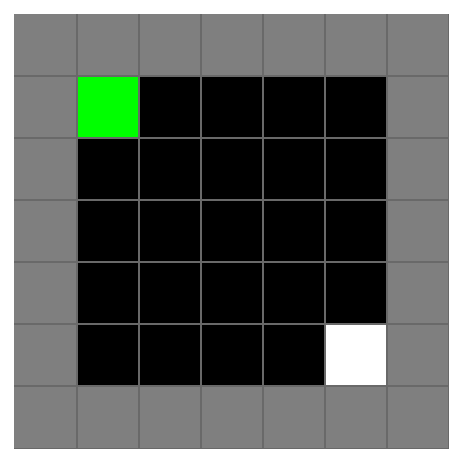

In [3]:
env = GridEnv(grid_size=GridSize.micro)
obs = env.reset()
env.render()

In the image above, the agent location is indicated by the white square, and the goal location is indicated by the green square. Grey squares correspond to walls, and black squares correspond to open space. 

The agent has four possible actions, movement up (0), right (1), down (2), or left (3). 

The agent can act in the environment by calling `env.step(action)`. This will return a new `observation`, `reward`, `done indication`, and `miscellaneous information`. We can ignore these last two for now.

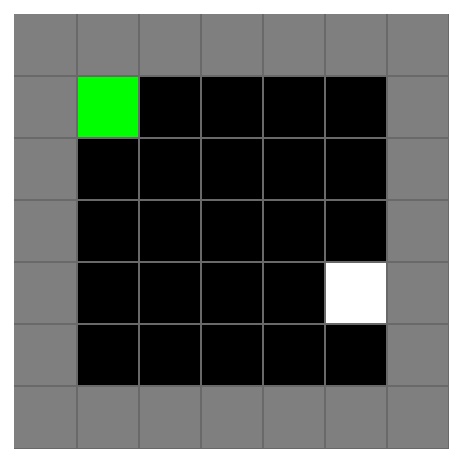

In [4]:
obs, reward, done, _ = env.step(0)  # Lets move up
env.render()  # This rendered the current state of the environment

We can keep moving the agent until it reaches the goal.

<Add printout for action number>

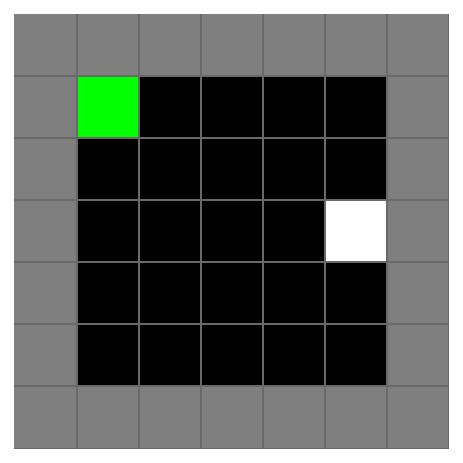

Action: 0, Reward: 0.0


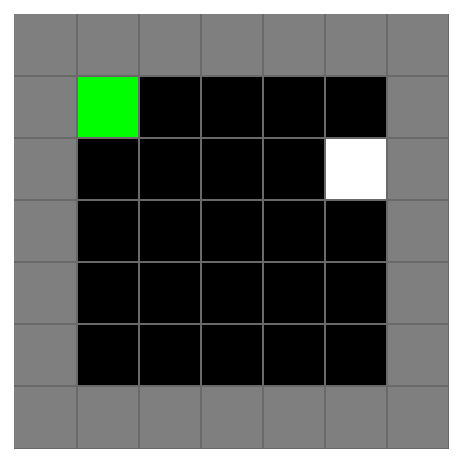

Action: 0, Reward: 0.0


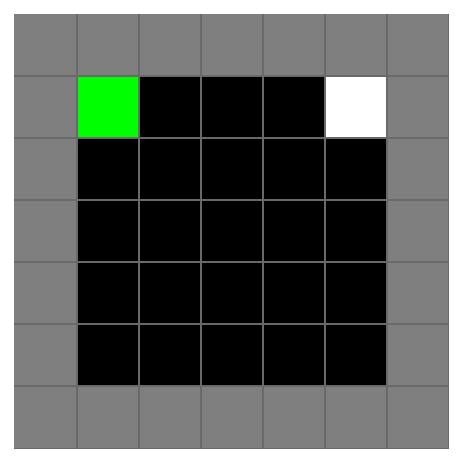

Action: 0, Reward: 0.0


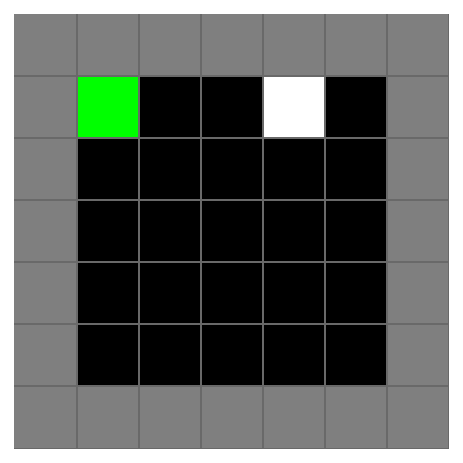

Action: 3, Reward: 0.0


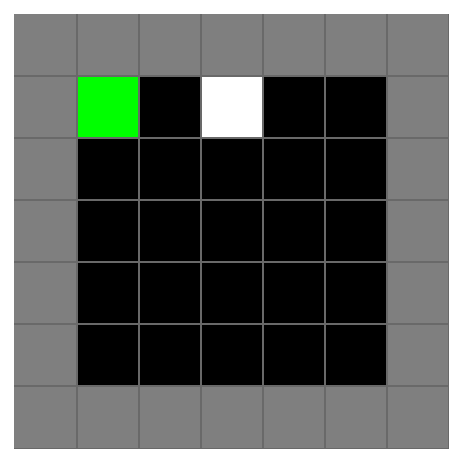

Action: 3, Reward: 0.0


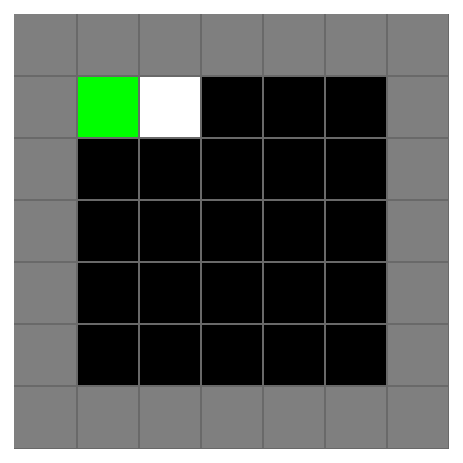

Action: 3, Reward: 0.0


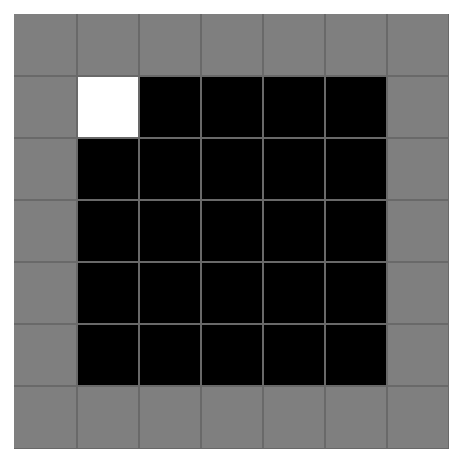

Action: 3, Reward: 1.0


In [5]:
actions = [0, 0, 0, 3, 3, 3, 3]  # The optimal action sequence

for idx, action in enumerate(actions):
    obs, reward, done, _ = env.step(action)
    env.render()
    print(f"Action: {action}, Reward: {reward}")

The agent reached the goal location! 

Of course, the point of reinforcement learning is to devise ways for agents to learn optimal actions on their own, rather than having humans hand-design action sequences. We will explore this next.

## 2. Model-free learning in bandit tasks
Before describing algorithms capable of solving mazes, we can begin with an even simpler learning problem: how can we derive an agent which learns to make the optimal choice among a set of possible actions. Named after the slot machines found in casinos, this class of problems is referred to as multi-arm bandits.

We can instantiate a simple environment, where the agent has three possible actions (`0`, `1`, or `2`) it can take, each with a unique possible outcome: a reward of `+1`, a reward of `+0.5` or a reward of `-1`. In this case, action `0` is optimal, but we would like an agent to learn that information from scratch.

![one_step](../images/notebooks/one_step.png)

Neuro-Nav includes a number of pre-defined environment structures and tasks. The list of the tasks and environments is available [here](../neuronav/envs/README.md).

/Users/ajuliani1/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


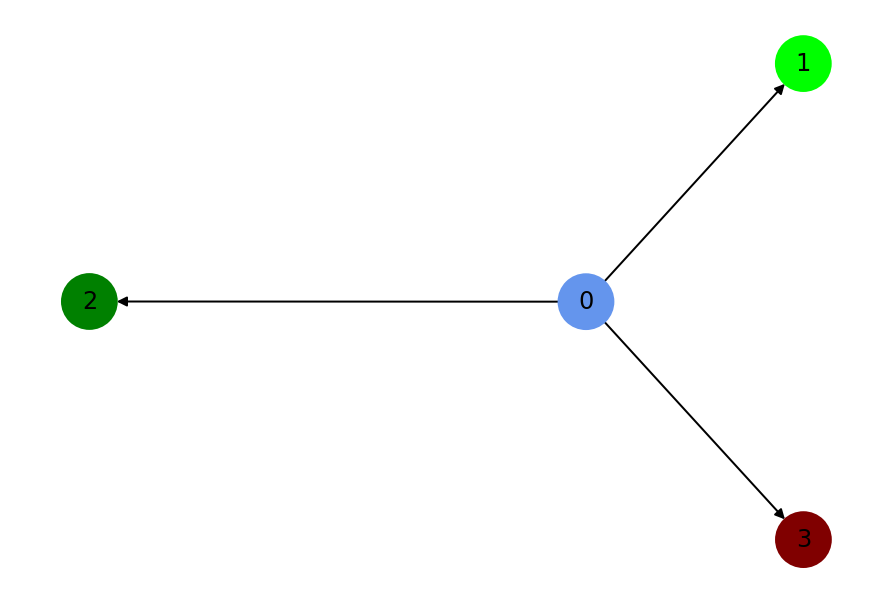

In [6]:
env = GraphEnv(graph_structure=GraphStructure.three_arm_bandit)
obs = env.reset()
env.render()

### Learning a Q-function by taking random actions

In order to learn the expected value of each action, we will use a simple form of value esimtation called Q-learning. In Q-learning, we learn a state-action value function called a Q-function. As it is a function of both the state and the action, it is often written as `Q(s,a)`. Since we have only one state from which we are trying to estimate the action values, we can also think of it as `Q(a)` in this context.

We can begin by instantiating a simple tabular Q learning agent. In this agent, the Q-function is a simple matrix, of shape `[NUM_ACTIONS X NUM_STATES]`. The code for this agent is available [here](../neuronav/agents/td_agents.py).

In [7]:
agent = TDQ(env.state_size, env.action_space.n)
print(f"Q-values: {agent.Q[:,0]}")

Q-values: [0. 0. 0.]


We can examine the first column of the matrix, since we are only concerned with learning action-values for the starting state. Since the agent has not learned anything yet, all the values are initialized to zero.

A simple update rule is then used to modify the Q values as the agent interacts with its environment.

$$Q(a) = Q(a) + \alpha * (r - Q(a))$$

Written in code this looks like:

`Q(a) = Q(a) + alpha * (r - Q(a))`

Where `alpha` is the learning rate, and `r` is the reward.

With Neuro-Nav, this update takes place automatically when passing the experience tuple `<obs, action, next_obs, reward>` to the `agent.update()` function.

We can see after 1000 trials of taking random actions that the agent's Q-values now match the true reward function of the environment.

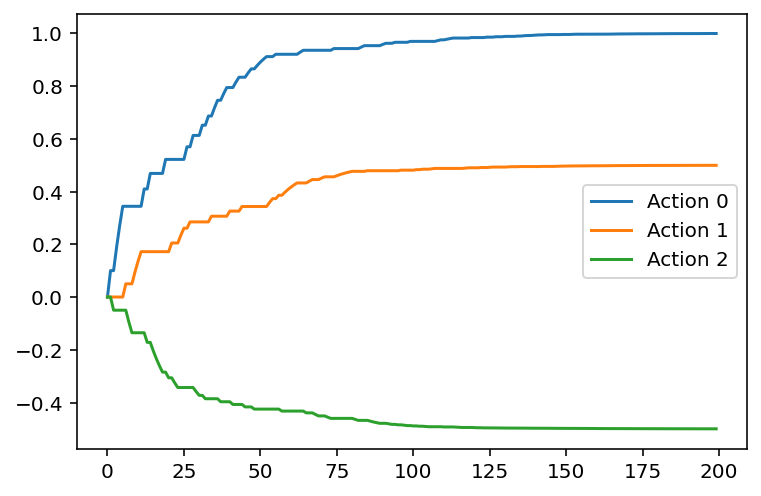

In [8]:
num_trials = 200

q_values = []
for i in range(num_trials):
    obs = env.reset()
    action = env.action_space.sample()
    next_obs, reward, _, _ = env.step(action)
    q_values.append(agent.Q[:, 0].copy())
    agent.update([obs, action, next_obs, reward])

plt.plot(q_values, label=["Action 0", "Action 1", "Action 2"])
plt.legend()

### Learning a Q-function while trading off exploration and exploitation

So far, our agent has been taking only random actions. In reality, we will want an agent which can balance exploration and exploitation during the learning process. Neuro-Nav includes two types of policies for negotiating this trade-off, a `softmax` policy, and an `egreedy` policy. 

The `softmax` policy weights the liklihood of each action by the current value estimate using a softmax function. 

The `egreedy` policy uses an `epsilon` parameter to determine the probablility of either taking the action with the highest value estimate, or a random action. 

The code for these two policy types is available [here](../neuronav/agents/base_agent.py).

Below we will examine using a `softmax` policy during learning in our bandit task.

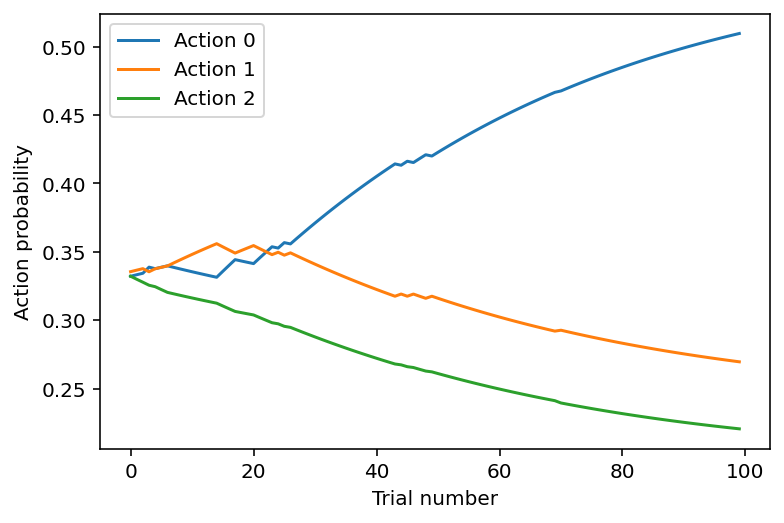

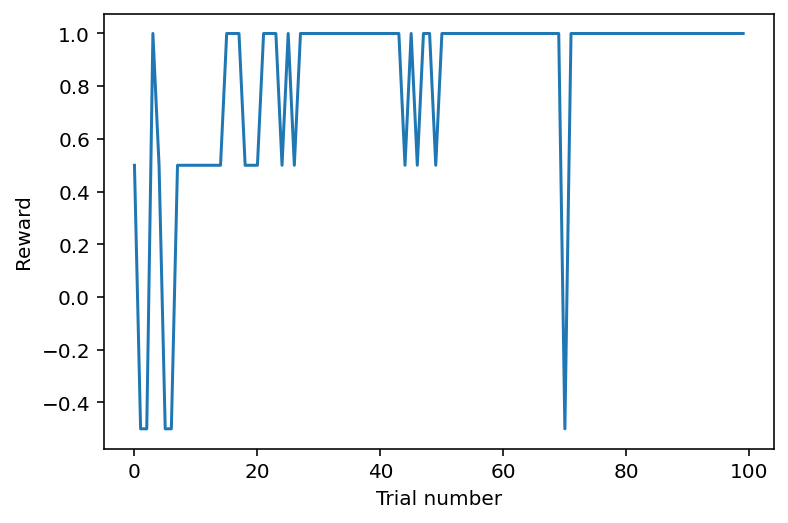

In [9]:
num_trials = 100

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=2e-2, beta=1e1)

rewards = []
probs = []
for i in range(num_trials):
    obs = env.reset()
    action = agent.sample_action(obs)
    next_obs, reward, _, _ = env.step(action)
    agent.update([obs, action, next_obs, reward])
    rewards.append(reward)
    probs.append(softmax(agent.Q[:, 0]))

plt.plot(probs, label=["Action 0", "Action 1", "Action 2"])
plt.legend()
_ = plt.ylabel("Action probability")
_ = plt.xlabel("Trial number")
plt.show()
plt.plot(rewards)
_ = plt.ylabel("Reward")
_ = plt.xlabel("Trial number")

As we can see, the agent quickly learns to favor the `0` action. This is reflected in the change in action probabilities, as well as the increase in episodic reward which comes from selecting the action which provides the `+1` reward.

## 3. Model-free learning in sequential decision making tasks

Most interesting problems involve sequences of decision, rather than single isolated actions. Here we extend the simple Q-learning algorithm to this class of sequential decision making problems. This is done by modifying the Q-learning update equation presented above as follows.

$$ Q(s, a) = Q(s, a) + \alpha * (r + \gamma * Q(s', a') - Q(s, a)) $$

Written in code this looks like:

`Q(s, a) = Q(s, a) + alpha * (r + gamma * (Q(s', a')) - Q(s, a))`

Where `gamma` is the discount factor, which determines how much to weight to place on expected future outcomes.

`s'` and `a'` likewise correspond to the next (or successor) state and action of the agent.

Intuitively, this equation corresponds to adjusting the state-action value estimate for a given state-action pair toward the observed reward plus a discounted estimate of future expected value. 

### Using Q-learning to solve a two-step task

We can examine how this learning process takes place in a slightly more complex environment. Below is a two-step decision making task, where the agent must make two binary decisions in a sequence. The optimal action sequence is `1, 0`, which leads to a reward of `+1`.

![two_step](../images/notebooks/two_step.png)

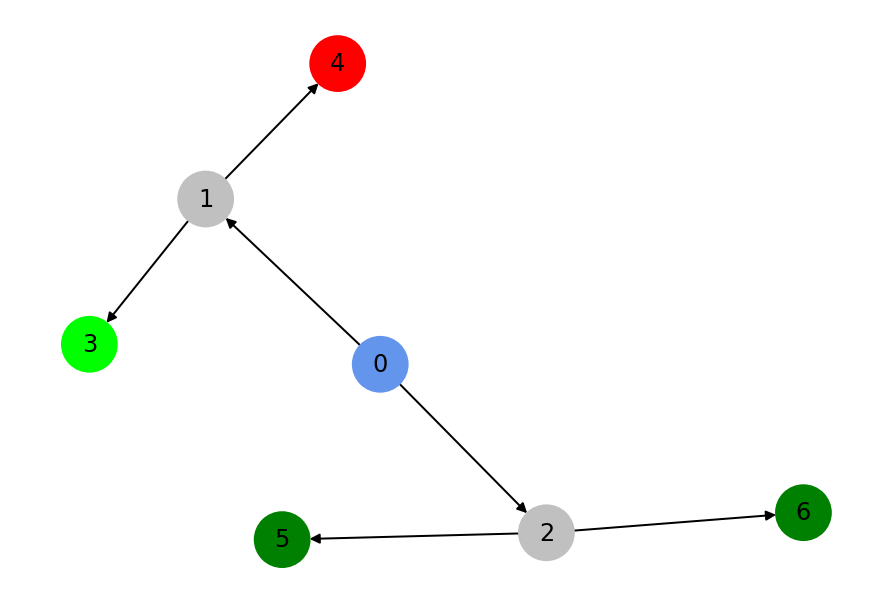

In [10]:
env = GraphEnv(graph_structure=GraphStructure.two_step)
obs = env.reset()
env.render()

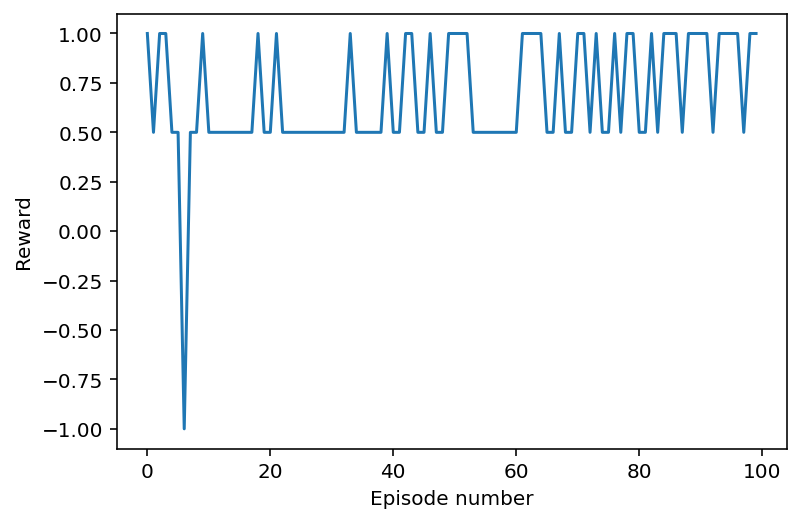

In [11]:
num_episodes = 100
lr = 5e-2
beta = 1e1

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=lr, beta=beta)

rewards = []
for i in range(num_episodes):
    done = False
    obs = env.reset()
    while not done:
        action = agent.sample_action(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.update([obs, action, next_obs, reward])
        obs = next_obs
    rewards.append(reward)

plt.plot(rewards)
_ = plt.ylabel("Reward")
_ = plt.xlabel("Episode number")

As is evident from the plot above, the agent learns after about 50 episodes to select the optimal action sequence.

### Using Q-learning to solve a maze navigation task

Finally, we can use the same Q-learning algorithm which solves the two-step task and apply it to our original maze environment, which involves much longer-term credit assignment.

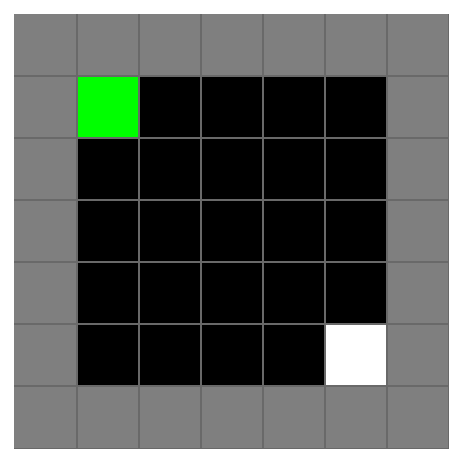

In [12]:
env = GridEnv(grid_size=GridSize.micro)
obs = env.reset()
env.render()

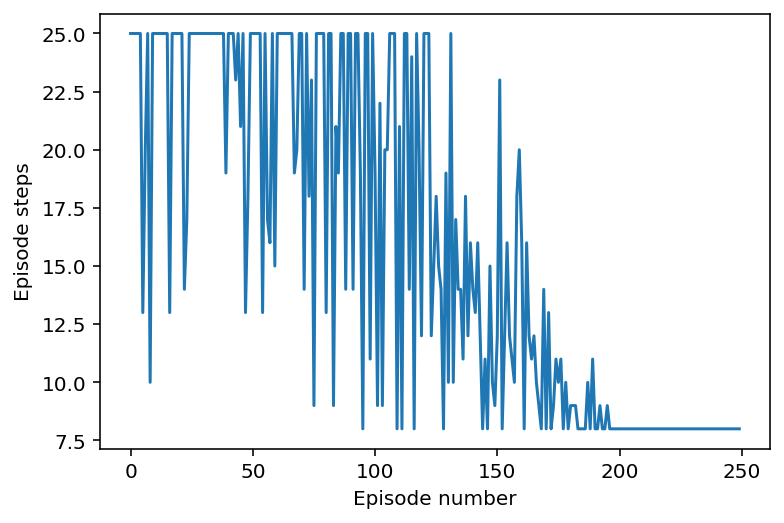

In [13]:
num_episodes = 250
num_steps = 25
lr = 5e-2
beta = 1e2

agent = TDQ(env.state_size, env.action_space.n, poltype="softmax", lr=lr, beta=beta)

episode_steps = []
for i in range(num_episodes):
    done = False
    steps = 0
    obs = env.reset()
    while not done and steps < num_steps:
        action = agent.sample_action(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.update([obs, action, next_obs, reward])
        obs = next_obs
        steps += 1
    episode_steps.append(steps)

plt.plot(episode_steps)
_ = plt.ylabel("Episode steps")
_ = plt.xlabel("Episode number")

After 200 episodes of experience, the agent has learned the optimal action sequence to reach the goal state.

We can visualize the learned value estimates for each state by averaging over the actions.

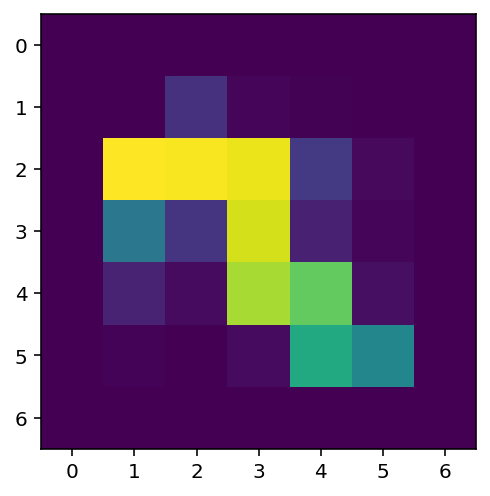

In [14]:
_ = plt.imshow(agent.Q.mean(0).reshape(7, 7))

Neuro-Nav also includes a tool to plot value and policy values automatically for a given agent and environment in a more clear fashion.

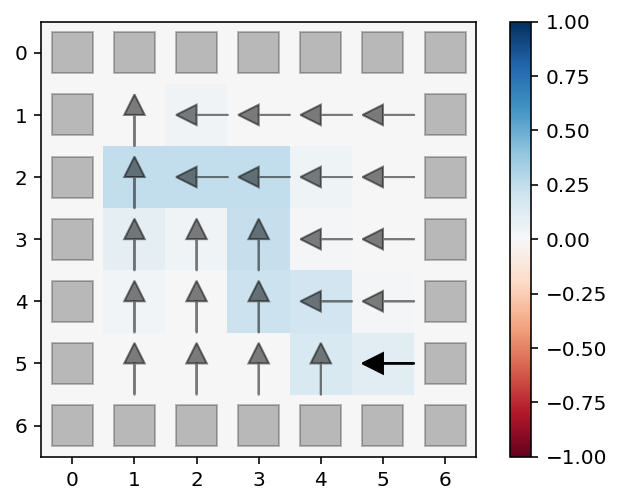

In [15]:
plot_values_and_policy(agent, env, env.agent_start_pos)

## 4. The successor representation

So far, we have focused on learning the set of state-action value estimates directly through experience. This works well in cases where the structure of the environment and the reward function remains fixed. What happens if the reward changes though? In this section and the next, we explore algorithms to deal with this change. The first such algorithm we will examine is the successor representation (SR).

In an SR algorithm instead of learning a single `Q(s, a)` matrix, two separate entities are learned: a reward function `w(s)`, and a successor matrix `M(s, s', a)`. These two can then be combined through matrix multiplication to recover the cannonical `Q(s, a)` function. Code for the SR algorithm is available [here](../neuronav/agents/td_agents.py).

### Examining learned representations from an SR agent

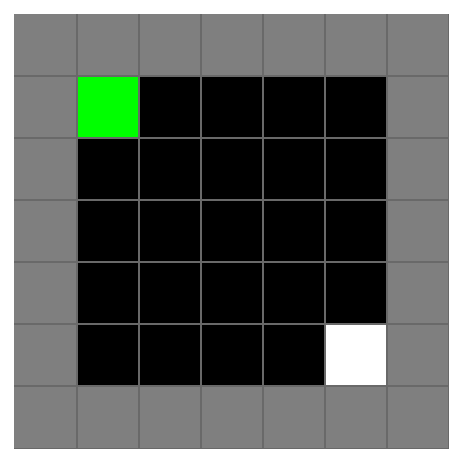

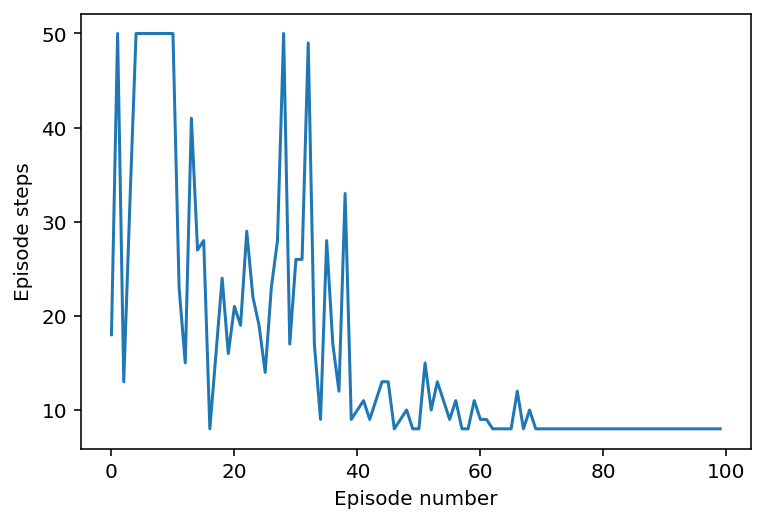

In [16]:
num_episodes = 100
num_steps = 50
lr = 5e-2

env = GridEnv(grid_size=GridSize.micro)
obs = env.reset()
env.render()

agent = TDSR(env.state_size, env.action_space.n, lr=lr)

episode_steps = []
for i in range(num_episodes):
    (
        agent,
        steps,
        _,
    ) = run_episode(env, agent, num_steps)
    episode_steps.append(steps)

plt.plot(episode_steps)
_ = plt.ylabel("Episode steps")
_ = plt.xlabel("Episode number")

We can plot the learned reward function `w(s)` below.

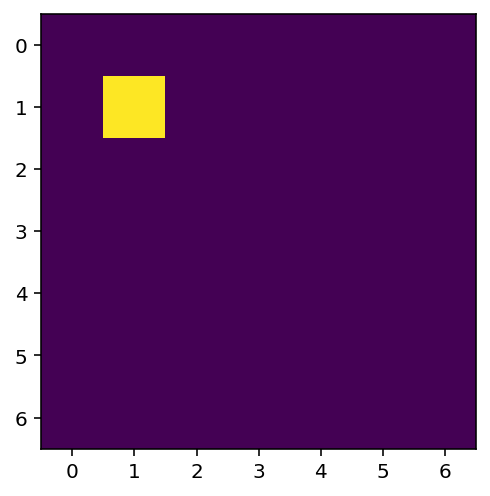

In [17]:
_ = plt.imshow(agent.w.reshape(env.grid_size, env.grid_size))

We can also plot a set of example units from the successor matrix `M(s, s', a)` below.

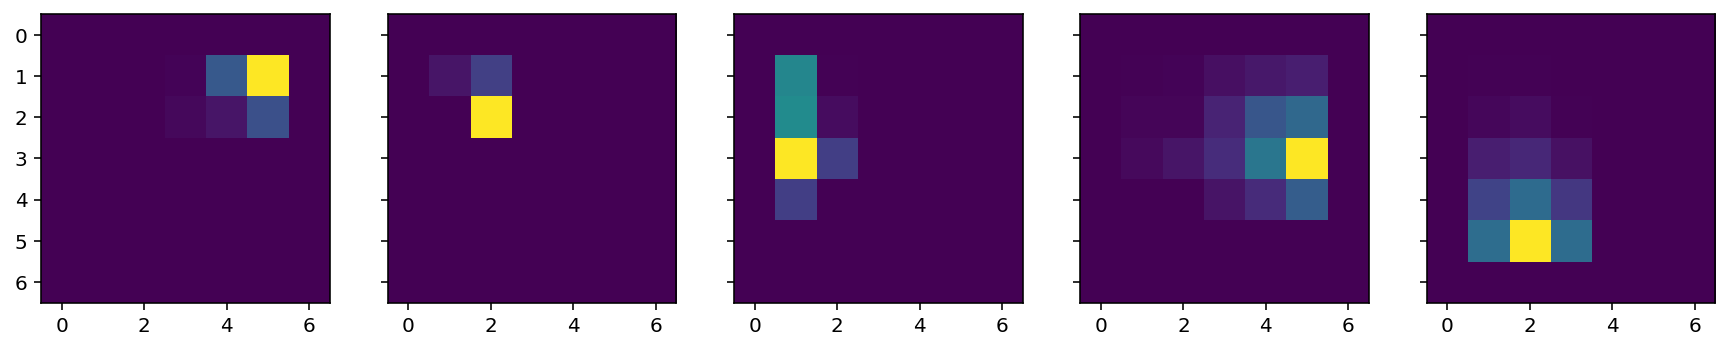

In [18]:
units = [12, 16, 22, 26, 37]

f, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 5))

for idx, unit in enumerate(units):
    axs[idx].imshow(
        np.sqrt(agent.M.mean(0)[unit].reshape(env.grid_size, env.grid_size))
    )
plt.show()

Lastly, it is possible to plot the Q-function which derives from combining the `w(s)` vector and `M(s, s', a)` matrix. 

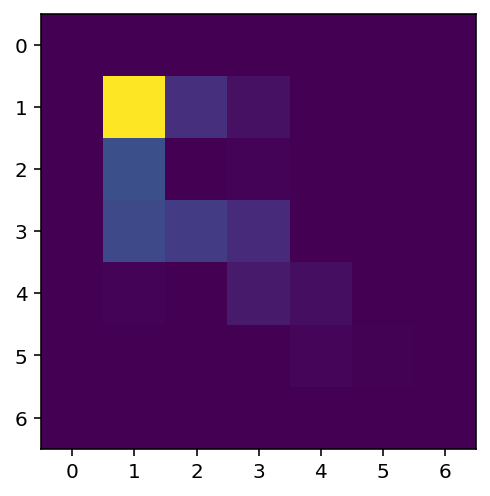

In [19]:
_ = plt.imshow(agent.Q.mean(0).reshape(env.grid_size, env.grid_size))

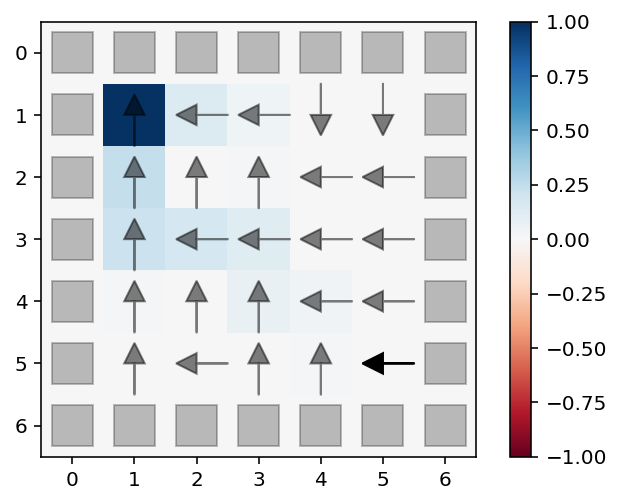

In [20]:
plot_values_and_policy(agent, env, env.agent_start_pos)

### Adapting to reward function changes with SR agents

The benefit of learning these entities separately is that different learning dynamics can involved for each, thus enabling faster adaptation to changes in the reward function `w(s)`, for example, while preserving learned knowledge about environment transition dynamics in `M(s, s', a)`. 

We explore this using a simple T-Maze, where the reward location starts at the left corner of the maze, and then switches to the right corner halfway through the learning process. The traditional Q learning algorithm is unable to adapt to this change, whereas the SR algorithm quickly adjusts its behavior to move toward the new goal location.

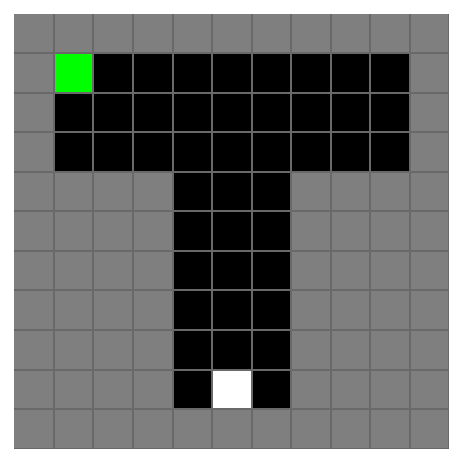

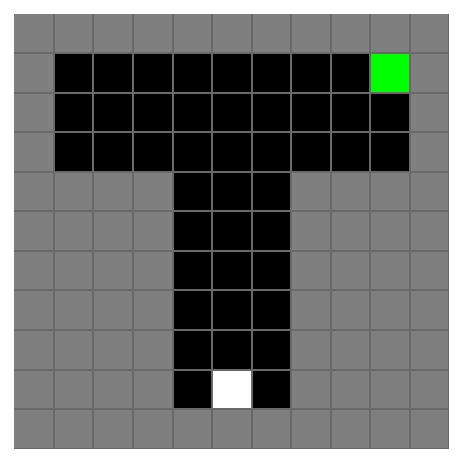

In [21]:
env = GridEnv(topography=GridTopography.t_maze)
obs = env.reset()
env.render()
obs = env.reset(reward_locs={(1, 9): 1})
env.render()

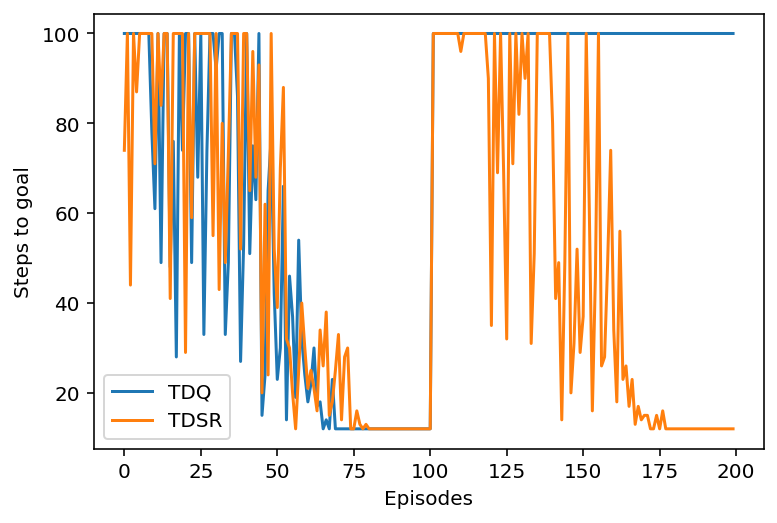

In [22]:
num_episodes = 200
switch_episode = 100
num_steps = 100
goal_loc_a = {(1, 1): 1}
goal_loc_b = {(1, 9): 1}

agent_q = TDQ(env.state_size, env.action_space.n)
agent_sr = TDSR(env.state_size, env.action_space.n)

agents = {"TDQ": agent_q, "TDSR": agent_sr}

for agent_name in agents:
    reward_locs = goal_loc_a
    steps = []
    for i in range(num_episodes):
        if i > switch_episode:
            reward_locs = goal_loc_b
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], num_steps, reward_locs=reward_locs
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.ylabel("Steps to goal")
_ = plt.xlabel("Episodes")

## 5. Experience replay with Dyna

Thus far we have considered agents which learn exclusively from online experience. Humans and many other animals can learn not only from the current experiences, but from their memories of past experiences. Here we introduce a memory capacity to agents with a form of experience replay called Dyna. 

Agents with Dyna are able to store and re-use past experiences to speed up the learning process, as well as preserve learning from low-probability experiences under the current policy. 

Below we compare a Q-learning agent with and without Dyna on the four-rooms maze navigation task. With the same set of hyperparameters, the Q-learning agent fails to learn the optimal policy within 500 episodes of experience, whereas the DynaQ agent learns the optimal policy in less than 250 episodes of experience.

Code for the Dyna variants of agents is available [here](../neuronav/agents/dyna_agents.py).

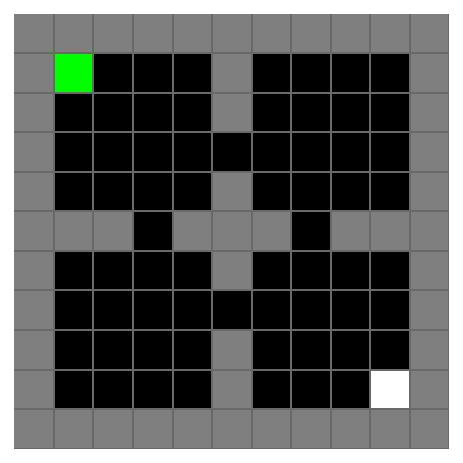

In [23]:
env = GridEnv(topography=GridTopography.four_rooms)
obs = env.reset()
env.render()

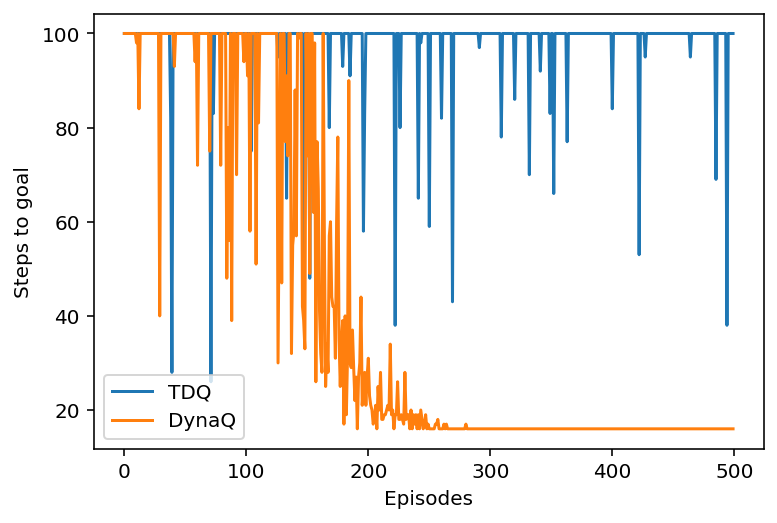

In [24]:
episode_steps = 100
num_episodes = 500
beta = 1e2
lr = 5e-2

agent_q = TDQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_dq = DynaQ(env.state_size, env.action_space.n, beta=beta, lr=lr)

agents = {"TDQ": agent_q, "DynaQ": agent_dq}

for agent_name in agents:
    steps = []
    for i in range(num_episodes):
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], episode_steps
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.ylabel("Steps to goal")
_ = plt.xlabel("Episodes")

## 6. Model-based algorithms

Finally, we can extend the idea of learning from past experiences even further. Rather than keeping track of a large dictionary of previous experiences, we can build a model of the reward function and transition dynamics, and use this to compute a Q-function on-the-fly. This belongs to a class of approaches called model-based algorithms. 

In particular, we will use a form of the algorithm called value iteration. There are multiple benefits of this approach. Like Dyna algorithms, it enables learning with fewer environmental interactions. It also enables adaptation to changes in the environment, since a change in the reward or transition dynamics can be quickly accounted for, and used to compute a new Q-function. On the other hand, this approach is much more computationally expensive, since it requires recomputing the Q-function iteratively for all state/action pairs. 

Below we compare a model-based algorithm (MBV) to a TDQ and DynaQ algorithm on a task where the transition dynamics of the environment change halfway through the learning process. In this case, a roadblock is introduced which requires the agent learning to take the longer detour route to the goal location.

Code for the model-based algorithm below is available [here](../neuronav/agents/mb_agents.py).

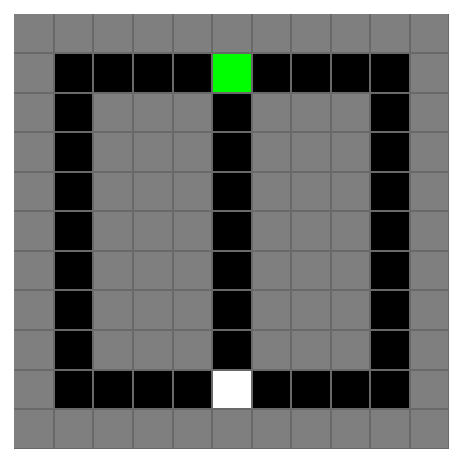

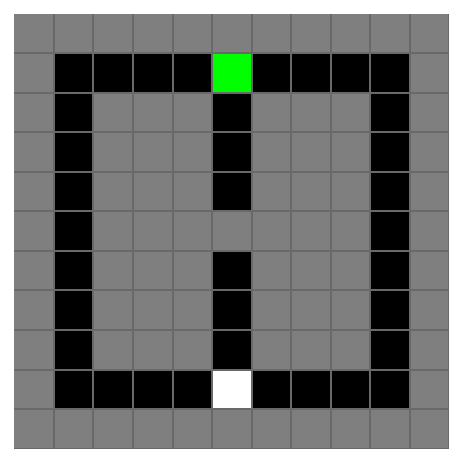

In [25]:
env = GridEnv(topography=GridTopography.detour)
obs = env.reset()
env.render()

env = GridEnv(topography=GridTopography.detour_block)
obs = env.reset()
env.render()

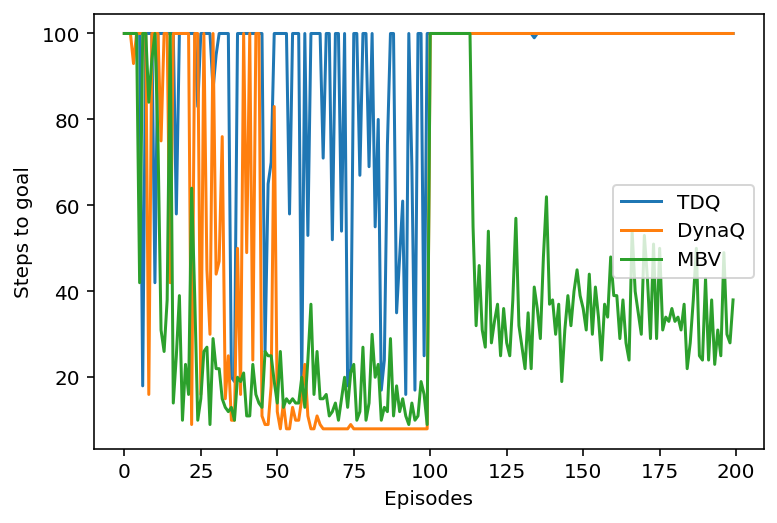

In [26]:
episode_steps = 100
num_episodes = 200
switch_episode = 100
beta = 1e2
lr = 5e-2

agent_q = TDQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_dq = DynaQ(env.state_size, env.action_space.n, beta=beta, lr=lr)
agent_vi = MBV(env.state_size, env.action_space.n, beta=beta, lr=lr)

agents = {"TDQ": agent_q, "DynaQ": agent_dq, "MBV": agent_vi}

for agent_name in agents:
    steps = []
    env = GridEnv(topography=GridTopography.detour)
    for i in range(num_episodes):
        if i == switch_episode:
            env = GridEnv(topography=GridTopography.detour_block)
        agents[agent_name], step, _ = run_episode(
            env, agents[agent_name], episode_steps
        )
        steps.append(step)
    plt.plot(steps, label=agent_name)
plt.legend()
_ = plt.ylabel("Steps to goal")
_ = plt.xlabel("Episodes")

As is apparent from the above graph, only the MBV agent is able to learn to adapt to the change in transition dynamics of the environment. This is because the Q function the agent uses can be recomputed based on changes in the underlying transition structure.

## 7. Next steps

The content presented in this tutorial notebook is meant to provide an overview of some of the relevant reinforcement learning algorithms used to study human and animal decision making. Here are some potential next steps:

* Learn about additional Neuro-Nav features in the [Usage Tutorial](./usage_tutorial.ipynb).

* Explore the other notebooks included in Neuro-Nav [here](./README.md).

* Explore the agent aglorithms included in Neuro-Nav [here](../neuronav/agents/README.md).

* Explore the environments and tasks included in Neuro-Nav [here](../neuronav/envs/README.md).

* Conduct your own experiment by comparing different algorithms, hyperparameters, and tasks.
